# *The code is optimized for minimum using RAM capacity by saving middle data in local storage*

# *MAIN INPUT INFORMATION FOR FORMATE OUTPUT RASTERS*

In [1]:
#  RN contamination of trunk wood
PL_Sr = int(input('Enter the permissible level for Sr-90 activity concentration in trunk wood (Bq/kg):'))
PL_Cs = int(input('Enter the permissible level for Cs-137 activity concentration in trunk wood (Bq/kg):'))


# Enter the year for which you want to get indicators (from 2020 to 2050)
year = int(input('Enter the year for which you want to receive indicators (from 2020 to 2050):'))
if year>2019 and year<2051 :
    print('\n************** \n Ok! \n**************\n')
else:
    print('\n************** \n Error! \n**************\n')

Enter the permissible level for Sr-90 activity concentration in trunk wood (Bq/kg): 60
Enter the permissible level for Cs-137 activity concentration in trunk wood (Bq/kg): 600
Enter the year for which you want to receive indicators (from 2020 to 2050): 2050



************** 
 Ok! 
**************



# *Prepare all input data*
# Load modules and raster data

In [2]:
# Import Python print function and division
from __future__ import print_function, division

# Import klepto, GDAL, NumPy, and matplotlib
import klepto
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Create local storage using 'klepto'
db = klepto.archives.dir_archive('db', serialized=True, cached=False)

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [3]:
# Block warnings messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read our raster`s bands/channels
"""
Raster bands includes:
0: Sr-90 density contamination of soil, 
1: Cs-137 density contamination of soil, 
2: ambient equivalent dose rate (ADER),
3: species ID, 
4: origin ID, 
5: stand age, 
6: stand height, 
7: stand DBH, 
8: relative stock,
9: soil fertility ID, 
11: the humidity of the soil 
"""
img_ds = gdal.Open('./input_raster/clip_comb_bands.tif', gdal.GA_ReadOnly)

# Copy the transformation to a variable
GT_input = img_ds.GetGeoTransform()

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

# Clear up RAM
img_ds = ''

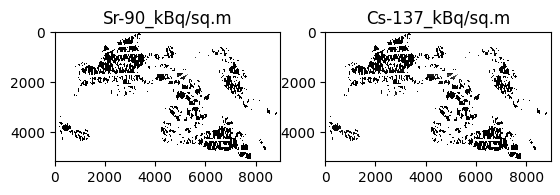

In [5]:
# Show bands
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('Sr-90_kBq/sq.m')

plt.subplot(122)
plt.imshow(img[:, :, 1], cmap=plt.cm.Greys_r)
plt.title('Cs-137_kBq/sq.m')

plt.show()

# Estimation of SI (Site index)

In [6]:
# Select bands for est. SI

db['X_SI'] = img[:, :, [3, 4, 5, 6]]

print('Our X matrix is sized: {sz}'.format(sz=db['X_SI'].shape))

Our X matrix is sized: (5154, 8981, 4)


In [7]:
#  Importing the main library for building model and its analysis

import xgboost as xgb
import pandas as pd

In [8]:
# Load learned model
xgb_model_SI = xgb.XGBRegressor()

xgb_model_SI.load_model('./models/growing_model/XGB_model_SI.txt')

In [9]:
# Show all parameters of XGBoost model

print(xgb_model_SI)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8658392694925228, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse'], feature_types=None,
             gamma=0.07811099757409967, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.28893005442828845, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=147, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [10]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
db['new_shape_X_SI'] = (db['X_SI'].shape[0] * db['X_SI'].shape[1], db['X_SI'].shape[2])

db['array_X_SI'] = db['X_SI'].reshape(db['new_shape_X_SI'])
print('Reshaped from {o} to {n}'.format(o=db['X_SI'].shape,
                                        n=db['array_X_SI'].shape))

Reshaped from (5154, 8981, 4) to (46288074, 4)


In [11]:
# Create predict values for each pixels for Site index
db['pred_SI'] = xgb_model_SI.predict(db['array_X_SI'], ntree_limit=xgb_model_SI.best_ntree_limit)

# Reshape our predict map
db['output_pred_SI'] = db['pred_SI'].reshape(db['X_SI'][:, :, 0].shape)

# Save prediction SI map

In [12]:
# Load "rasterio" library
import rasterio

In [13]:
# Save output raster
from affine import Affine
af_transf = Affine.from_gdal(*GT_input)

with rasterio.open(
    './output_rasters/00_SI_map.tif',
    'w',
    driver='GTiff',
    height=db['output_pred_SI'].shape[0],
    width=db['output_pred_SI'].shape[1],
    count=1,
    dtype=np.float32,
    transform=af_transf
) as dest_file:
    dest_file.write(db['output_pred_SI'], 1)
dest_file.close()

# Calculate forest parameters

In [14]:
# Calculate stands probobly parameters when RS/P = 1

# Formate array data for species_ID and origin_ID:
db['X_Sp_Or'] = img[:, :, [3, 4]]    

db['new_shape_norm_X_Sp_Or'] = (db['X_Sp_Or'].shape[0] * db['X_Sp_Or'].shape[1], db['X_Sp_Or'].shape[2])
db['array_norm_X_Sp_Or'] = db['X_Sp_Or'].reshape(db['new_shape_norm_X_Sp_Or'])
    
# Formate array data for A:
db['X_A'] = img[:, :, [5]]    

db['new_shape_norm_X_A'] = (db['X_A'].shape[0] * db['X_A'].shape[1], db['X_A'].shape[2])
db['array_norm_X_A'] = db['X_A'].reshape(db['new_shape_norm_X_A'])

In [15]:
# Unit array data for est. forest normal stand parameters 
db['X_norm_FP'] = np.c_[db['array_norm_X_Sp_Or'], db['pred_SI'], db['array_norm_X_A']]

In [16]:
# Load learned XGBoost models for est parameters of normal forest stands
xgb_model_D = xgb.XGBRegressor()
xgb_model_D.load_model('./models/growing_model/XGB_model_ln_D_THR_data.txt')

xgb_model_H = xgb.XGBRegressor()
xgb_model_H.load_model('./models/growing_model/XGB_model_ln_H_THR_data.txt')

xgb_model_G = xgb.XGBRegressor()
xgb_model_G.load_model('./models/growing_model/XGB_model_ln_G_THR_data.txt')

xgb_model_GS = xgb.XGBRegressor()
xgb_model_GS.load_model('./models/growing_model/XGB_model_ln_GS_THR_data.txt')

In [17]:
# Create predict values for parameters as normal forest stands
db['pred_ln_D1'] = xgb_model_D.predict(db['X_norm_FP'], ntree_limit=xgb_model_D.best_ntree_limit)

db['pred_ln_H1'] = xgb_model_H.predict(db['X_norm_FP'], ntree_limit=xgb_model_H.best_ntree_limit)

db['pred_ln_G1'] = xgb_model_G.predict(db['X_norm_FP'], ntree_limit=xgb_model_G.best_ntree_limit)

db['pred_ln_GS1'] = xgb_model_GS.predict(db['X_norm_FP'], ntree_limit=xgb_model_GS.best_ntree_limit)

db['pred_D1'] = np.exp(db['pred_ln_D1'])

db['pred_H1'] = np.exp(db['pred_ln_H1'])

db['pred_G1'] = np.exp(db['pred_ln_G1'])

db['pred_GS1'] = np.exp(db['pred_ln_GS1'])

In [18]:
# Ration between empirical and normal values of forest indicators
db['D'] = img[:, :, [7]]
db['new_shape_D'] = (db['D'].shape[0] * db['D'].shape[1], db['D'].shape[2])
db['array_D'] = db['D'].reshape(db['new_shape_D'])
db['ratio_D'] = np.divide(db['array_D'][:,0], db['pred_D1'])

db['H'] = img[:, :, [6]]
db['new_shape_H'] = (db['H'].shape[0] * db['H'].shape[1], db['H'].shape[2])
db['array_H'] = db['H'].reshape(db['new_shape_H'])
db['ratio_H'] = np.divide(db['array_H'][:,0], db['pred_H1'])

db['P'] = img[:, :, [8]] # relative stocking
db['new_shape_P'] = (db['P'].shape[0] * db['P'].shape[1], db['P'].shape[2])
db['array_P'] = db['P'].reshape(db['new_shape_P'])

db['G'] = np.multiply(db['array_P'][:,0], db['pred_G1'])
db['GS'] = np.multiply(db['array_P'][:,0], db['pred_GS1'])

In [19]:
# Calculate forest  parameters for years
a_stand = year-2016

db['A_forecast'] = db['array_norm_X_A'][:,0]+a_stand # stand age
db['FP_forecast'] = np.c_[db['array_norm_X_Sp_Or'], db['pred_SI'], db['A_forecast']]

# Create predict values for parameters as normal forest stands
db['pred_ln_D2'] = xgb_model_D.predict(db['FP_forecast'], ntree_limit=xgb_model_D.best_ntree_limit)
db['pred_ln_H2'] = xgb_model_H.predict(db['FP_forecast'], ntree_limit=xgb_model_H.best_ntree_limit)
db['pred_ln_G2'] = xgb_model_G.predict(db['FP_forecast'], ntree_limit=xgb_model_G.best_ntree_limit)
db['pred_ln_GS2'] = xgb_model_GS.predict(db['FP_forecast'], ntree_limit=xgb_model_GS.best_ntree_limit)

db['pred_D2'] = np.exp(db['pred_ln_D2'])
db['pred_H2'] = np.exp(db['pred_ln_H2'])
db['pred_G2'] = np.exp(db['pred_ln_G2'])
db['pred_GS2'] = np.exp(db['pred_ln_GS2'])

In [20]:
# Output results for forest stand parameters
db['output_D2'] = np.multiply(db['ratio_D'], db['pred_D2'])
db['output_H2'] = np.multiply(db['ratio_H'], db['pred_H2'])
db['output_G2'] = np.multiply(db['array_P'][:,0], db['pred_G2'])
db['output_GS2'] = np.multiply(db['array_P'][:,0], db['pred_GS2'])

In [21]:
# Est. biomass use my models

# Prepeare data
db['biomass_forecast_X'] = np.c_[db['array_norm_X_Sp_Or'], db['output_H2'], db['output_D2'], db['output_G2']]

In [22]:
# Load XGBooost models
xgb_model_GS = xgb.XGBRegressor()
xgb_model_allStem = xgb.XGBRegressor()
xgb_model_stemBark = xgb.XGBRegressor()
xgb_model_br = xgb.XGBRegressor()
xgb_model_f = xgb.XGBRegressor()
xgb_model_GS.load_model('./models/biomass_model/01_LN_CS_other_authors_XGB_model.json')
xgb_model_allStem.load_model('./models/biomass_model/02_LN_M_all_stem_other_authors_XGB_model.json')
xgb_model_stemBark.load_model('./models/biomass_model/03_LN_M_stem_bark_other_authors_XGB_model.json')
xgb_model_br.load_model('./models/biomass_model/04_LN_M_branch_other_authors_XGB_model.json')
xgb_model_f.load_model('./models/biomass_model/05_LN_M_foliage_other_authors_XGB_model.json')

#Predict parameters
db['pred_my_ln_GS'] = xgb_model_GS.predict(db['biomass_forecast_X'], ntree_limit=xgb_model_GS.best_ntree_limit)
db['pred_my_ln_allStem'] = xgb_model_allStem.predict(db['biomass_forecast_X'], ntree_limit=xgb_model_allStem.best_ntree_limit)
db['pred_my_ln_stemBark'] = xgb_model_stemBark.predict(db['biomass_forecast_X'], ntree_limit=xgb_model_stemBark.best_ntree_limit)
db['pred_my_ln_br'] = xgb_model_br.predict(db['biomass_forecast_X'], ntree_limit=xgb_model_br.best_ntree_limit)
db['pred_my_ln_f'] = xgb_model_f.predict(db['biomass_forecast_X'], ntree_limit=xgb_model_f.best_ntree_limit)

In [23]:
# Convert predicted parameters to real values
db['pred_my_GS'] = np.exp(db['pred_my_ln_GS'])
db['pred_my_allStem'] = np.exp(db['pred_my_ln_allStem'])
db['pred_my_stemBark'] = np.exp(db['pred_my_ln_stemBark'])
db['pred_my_br'] = np.exp(db['pred_my_ln_br'])
db['pred_my_f'] = np.exp(db['pred_my_ln_f'])

In [24]:
# Calculating the total above-ground biomass
db['pred_my_AG_biomass'] = db['pred_my_allStem'] + db['pred_my_br'] + db['pred_my_f']

In [25]:
# Reshape our predict maps for forest parameters
db['final_D2'] = db['output_D2'].reshape(db['X_A'][:, :, 0].shape)
db['final_H2'] = db['output_H2'].reshape(db['X_A'][:, :, 0].shape)
db['final_G2'] = db['output_G2'].reshape(db['X_A'][:, :, 0].shape)
db['final_GS2'] = db['output_GS2'].reshape(db['X_A'][:, :, 0].shape)

db['final_my_GS'] = db['pred_my_GS'].reshape(db['X_A'][:, :, 0].shape)
db['final_my_allStem'] = db['pred_my_allStem'].reshape(db['X_A'][:, :, 0].shape)
db['final_my_stemBark'] = db['pred_my_stemBark'].reshape(db['X_A'][:, :, 0].shape)
db['final_my_br'] = db['pred_my_br'].reshape(db['X_A'][:, :, 0].shape)
db['final_my_f'] = db['pred_my_f'].reshape(db['X_A'][:, :, 0].shape)
db['final_my_AG_biomass'] = db['pred_my_AG_biomass'].reshape(db['X_A'][:, :, 0].shape)

# *Preporation RN data*

In [26]:
# RN decay
# calculation 
decay_time = year-2020
decay_Sr = 1*2**(-decay_time/28.91)
decay_Cs = 1*2**(-decay_time/30.08)

In [27]:
# Convert into array RN bands
db['X_RN'] = img[:, :, [0, 1, 2]]

# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
db['new_shape_X_RN'] = (db['X_RN'].shape[0] * db['X_RN'].shape[1], db['X_RN'].shape[2])

db['array_X_RN'] = db['X_RN'].reshape(db['new_shape_X_RN'])
print('Reshaped from {o} to {n}'.format(o=db['X_RN'].shape,
                                        n=db['array_X_RN'].shape))

Reshaped from (5154, 8981, 3) to (46288074, 3)


In [28]:
# Calculation of RN concentration and AEDR as of "year"
db['output_Sr'] = db['array_X_RN'][:,0] * decay_Sr
db['output_Cs'] = db['array_X_RN'][:,1] * decay_Cs
db['output_AEDR'] = ((db['array_X_RN'][:,2]-0.1) * decay_Cs)+0.1

In [29]:
# Calculation of RN concentration in trunk wood as of "year"

db['X_Sp'] = img[:, :, [3]] # select species band
db['new_shape_X_Sp'] = (db['X_Sp'].shape[0] * db['X_Sp'].shape[1], db['X_Sp'].shape[2])
db['array_X_Sp'] = db['X_Sp'].reshape(db['new_shape_X_Sp'])

db['X_Fsoil'] = img[:, :, [9]] # select soil fertility band
db['new_shape_X_Fsoil'] = (db['X_Fsoil'].shape[0] * db['X_Fsoil'].shape[1], db['X_Fsoil'].shape[2])
db['array_X_Fsoil'] = db['X_Fsoil'].reshape(db['new_shape_X_Fsoil'])
              
# Created array for predict of RN activity concentration of stem wood
db['Wood_AC_Sr_forecast_X'] = np.c_[db['array_X_Sp'], db['output_D2'], db['array_X_Fsoil'], db['output_AEDR'], db['output_Sr']]
db['Wood_AC_Cs_forecast_X'] = np.c_[db['array_X_Sp'], db['output_D2'], db['output_H2'], db['output_G2'], db['A_forecast'], db['array_X_Fsoil'], db['output_AEDR']]

# Load XGBooost models
xgb_model_ln_Sr_wood = xgb.XGBRegressor()
xgb_model_ln_Cs_wood = xgb.XGBRegressor()

xgb_model_ln_Sr_wood.load_model('./models/RN_models/02_LN_Sr_content_without_geo_XGB_model_2024_final.json')
xgb_model_ln_Cs_wood.load_model('./models/RN_models/01_LN_Cs_content_without_geo_XGB_model_2024_final.json')

# Predict parameters
db['pred_ln_Sr_wood'] = xgb_model_ln_Sr_wood.predict(db['Wood_AC_Sr_forecast_X'], ntree_limit=xgb_model_ln_Sr_wood.best_ntree_limit)
db['pred_ln_Cs_wood'] = xgb_model_ln_Cs_wood.predict(db['Wood_AC_Cs_forecast_X'], ntree_limit=xgb_model_ln_Cs_wood.best_ntree_limit)

In [30]:
# Preprocessing RN and AEDR data before transfer into raster

# Convert predicted parameters to real values
db['pred_Sr_wood'] = np.exp(db['pred_ln_Sr_wood'])
db['pred_Cs_wood'] = np.exp(db['pred_ln_Cs_wood'])

# Reshape our predict maps for RN contaminated of stem wood
db['final_Sr_wood'] = db['pred_Sr_wood'].reshape(db['X_A'][:, :, 0].shape)
db['final_Cs_wood'] = db['pred_Cs_wood'].reshape(db['X_A'][:, :, 0].shape)

In [31]:
# Assessment of radiation dose rates to tree trunk wood

# load "math" and "scipy" libraries
from scipy.stats import norm
import math

# preprocessing
db['massTree'] = db['pred_my_allStem']*1000/(db['output_G2']/((math.pi*(db['output_D2']/100)**2)/4))
db['Sr_in_dose'] = (0.000594*db['massTree']**0.01435)*db['pred_Sr_wood']
db['Cs_in_dose'] = (0.0001764*db['massTree']**0.0934)*db['pred_Cs_wood']
db['In_dose'] = db['Sr_in_dose'] + db['Cs_in_dose']
db['Ex_dose'] = db['output_AEDR'] - (0.02*np.log(db['output_AEDR']) + 0.14)
db['Total_dose'] = db['In_dose'] + db['Ex_dose']
db['Part_in_dose'] = db['In_dose'] / db['Total_dose'] * 100

db['final_Sr_in_dose'] = db['Sr_in_dose'].reshape(db['X_A'][:, :, 0].shape)
db['final_Cs_in_dose'] = db['Cs_in_dose'].reshape(db['X_A'][:, :, 0].shape)
db['final_In_dose'] = db['In_dose'].reshape(db['X_A'][:, :, 0].shape)
db['final_Ex_dose'] = db['Ex_dose'].reshape(db['X_A'][:, :, 0].shape)
db['final_Total_dose'] = db['Total_dose'].reshape(db['X_A'][:, :, 0].shape)
db['final_Part_in_dose'] = db['Part_in_dose'].reshape(db['X_A'][:, :, 0].shape)

In [32]:
# Prediction of the trees/woods portion that is not exceeding the permissible levels of wood contamination
# for Sr-90
db['ratio_Sr_wood'] = db['pred_Sr_wood']/PL_Sr
db['Z_scope_Sr_wood'] = np.log(db['ratio_Sr_wood'])/np.log(1.6)
db['Part_wood_to_PL_Sr'] = norm(loc = 0 , scale = 1).cdf(db['Z_scope_Sr_wood'])

# for Cs-137
db['ratio_Cs_wood'] = db['pred_Cs_wood']/PL_Cs
db['Z_scope_Cs_wood'] = np.log(db['ratio_Cs_wood'])/np.log(1.6)
db['Part_wood_to_PL_Cs'] = norm(loc = 0 , scale = 1).cdf(db['Z_scope_Cs_wood'])

# final output values
db['final_Part_wood_to_PL_Sr'] = db['Part_wood_to_PL_Sr'].reshape(db['X_A'][:, :, 0].shape)
db['final_Part_wood_to_PL_Cs'] = db['Part_wood_to_PL_Cs'].reshape(db['X_A'][:, :, 0].shape)

In [33]:
# Clean up local storage
clean = []

db['X_SI'] = clean
db['new_shape_X_SI'] = clean
db['array_X_SI'] = clean 

db['X_Sp_Or'] = clean
db['new_shape_norm_X_Sp_Or'] = clean
db['array_norm_X_Sp_Or'] = clean
db['new_shape_norm_X_A'] = clean

db['pred_ln_D1'] = clean
db['pred_ln_H1'] = clean
db['pred_ln_G1'] = clean
db['pred_ln_GS1'] = clean

db['D'] = clean
db['new_shape_D'] = clean
db['array_D'] = clean
db['ratio_D'] = clean
db['H'] = clean
db['new_shape_H'] = clean
db['array_H'] = clean
db['ratio_H'] = clean
db['P'] = clean
db['new_shape_P'] = clean
db['array_P'] = clean
db['G'] = clean
db['GS'] = clean

db['FP_forecast'] = clean

db['pred_ln_D2'] = clean
db['pred_ln_H2'] = clean
db['pred_ln_G2'] = clean
db['pred_ln_GS2'] = clean
db['pred_D2'] = clean
db['pred_H2'] = clean
db['pred_G2'] = clean
db['pred_GS2'] = clean

db['biomass_forecast_X'] = clean

db['pred_my_ln_GS'] = clean
db['pred_my_ln_allStem'] = clean
db['pred_my_ln_stemBark'] = clean
db['pred_my_ln_br'] = clean
db['pred_my_ln_f'] = clean

db['X_RN'] = clean
db['new_shape_X_RN'] = clean
db['array_X_RN'] = clean
db['output_Sr'] = clean
db['output_Cs'] = clean
db['output_AEDR'] = clean

db['X_Sp'] = clean
db['new_shape_X_Sp'] = clean
db['X_Fsoil'] = clean
db['new_shape_X_Fsoil'] = clean
db['array_X_Fsoil'] = clean

db['Wood_AC_Sr_forecast_X'] = clean
db['Wood_AC_Cs_forecast_X'] = clean

db['massTree'] = clean
db['Sr_in_dose'] = clean
db['Cs_in_dose'] = clean
db['In_dose'] = clean
db['Ex_dose'] = clean
db['Total_dose'] = clean
db['Part_in_dose'] = clean

db['ratio_Sr_wood'] = clean
db['Z_scope_Sr_wood'] = clean
db['Part_wood_to_PL_Sr'] = clean
db['ratio_Cs_wood'] = clean
db['Z_scope_Cs_wood'] = clean
db['Part_wood_to_PL_Cs'] = clean

# Est. of RN stock in AG biomass

In [34]:
# Reclassfication species_ID
db['neg_invers_array_X_Sp'] = db['array_X_Sp'] * -1

In [35]:
# Ratio between RN activity concentration in biomass component and trunk wood ([trunk bark, branch, foliage])
ratio_Cs_Pine = [3, 3, 5]
ratio_Sr_Pine = [4, 3.5, 3]
ratio_Cs_Spruce = [3, 3, 5]
ratio_Sr_Spruce = [4, 3.5, 3]
ratio_Cs_Birch = [2, 2, 3]
ratio_Sr_Birch = [6, 5, 7]
ratio_Cs_Alder = [1.8, 2, 3]
ratio_Sr_Alder = [2, 2, 2.5]
ratio_Cs_Aspen = [1.8, 2, 3]
ratio_Sr_Aspen = [2, 2, 2.5]
ratio_Cs_Oak = [4, 1.5, 6.5]
ratio_Sr_Oak = [11, 4, 3.5]

# The inverse of species ID 
species_name = [0, -1, -2, -3, -4, -5]

In [36]:
# Func. for full reclassification data
def est_ratio (ratio_data, raster, species):
    for i in range(len(ratio_data)):
        global a
        a=ratio_data
        globals()[f'comp_{i}'] = np.where(raster == species, ratio_data[i], 0)      

In [37]:
# Calc. ratio for RN in different components
# for Cs-137
est_ratio(ratio_Cs_Pine, db['neg_invers_array_X_Sp'], 0)
db['ratio_Pine_comp_0'] = comp_0
db['ratio_Pine_comp_1'] = comp_1
db['ratio_Pine_comp_2'] = comp_2

est_ratio(ratio_Cs_Spruce, db['neg_invers_array_X_Sp'], -1)
db['ratio_Spruce_comp_0'] = comp_0
db['ratio_Spruce_comp_1'] = comp_1
db['ratio_Spruce_comp_2'] = comp_2

est_ratio(ratio_Cs_Birch, db['neg_invers_array_X_Sp'], -2)
db['ratio_Birch_comp_0'] = comp_0
db['ratio_Birch_comp_1'] = comp_1
db['ratio_Birch_comp_2'] = comp_2

est_ratio(ratio_Cs_Alder, db['neg_invers_array_X_Sp'], -3)
db['ratio_Alder_comp_0'] = comp_0
db['ratio_Alder_comp_1'] = comp_1
db['ratio_Alder_comp_2'] = comp_2

est_ratio(ratio_Cs_Aspen, db['neg_invers_array_X_Sp'], -4)
db['ratio_Aspen_comp_0']  = comp_0
db['ratio_Aspen_comp_1'] = comp_1
db['ratio_Aspen_comp_2'] = comp_2

est_ratio(ratio_Cs_Oak, db['neg_invers_array_X_Sp'], -5)
db['ratio_Oak_comp_0'] = comp_0
db['ratio_Oak_comp_1'] = comp_1
db['ratio_Oak_comp_2'] = comp_2

db['ratio_Cs_comp_0'] = db['ratio_Pine_comp_0'] + db['ratio_Spruce_comp_0'] + db['ratio_Birch_comp_0'] + db['ratio_Alder_comp_0'] + db['ratio_Aspen_comp_0'] + db['ratio_Oak_comp_0']
db['ratio_Cs_comp_1'] = db['ratio_Pine_comp_1'] + db['ratio_Spruce_comp_1'] + db['ratio_Birch_comp_1'] + db['ratio_Alder_comp_1'] + db['ratio_Aspen_comp_1'] + db['ratio_Oak_comp_1']
db['ratio_Cs_comp_2'] = db['ratio_Pine_comp_2'] + db['ratio_Spruce_comp_2'] + db['ratio_Birch_comp_2'] + db['ratio_Alder_comp_2'] + db['ratio_Aspen_comp_2'] + db['ratio_Oak_comp_2']

# for Sr-90
est_ratio(ratio_Sr_Pine, db['neg_invers_array_X_Sp'], 0)
db['ratio_Pine_comp_0'] = comp_0
db['ratio_Pine_comp_1'] = comp_1
db['ratio_Pine_comp_2'] = comp_2

est_ratio(ratio_Sr_Spruce, db['neg_invers_array_X_Sp'], -1)
db['ratio_Spruce_comp_0'] = comp_0
db['ratio_Spruce_comp_1'] = comp_1
db['ratio_Spruce_comp_2'] = comp_2

est_ratio(ratio_Sr_Birch, db['neg_invers_array_X_Sp'], -2)
db['ratio_Birch_comp_0'] = comp_0
db['ratio_Birch_comp_1'] = comp_1
db['ratio_Birch_comp_2'] = comp_2

est_ratio(ratio_Sr_Alder, db['neg_invers_array_X_Sp'], -3)
db['ratio_Alder_comp_0'] = comp_0
db['ratio_Alder_comp_1'] = comp_1
db['ratio_Alder_comp_2'] = comp_2

est_ratio(ratio_Sr_Aspen, db['neg_invers_array_X_Sp'], -4)
db['ratio_Aspen_comp_1']  = comp_0
db['ratio_Aspen_comp_1'] = comp_1
db['ratio_Aspen_comp_2'] = comp_2

est_ratio(ratio_Sr_Oak, db['neg_invers_array_X_Sp'], -5)
db['ratio_Oak_comp_0'] = comp_0
db['ratio_Oak_comp_1'] = comp_1
db['ratio_Oak_comp_2'] = comp_2

db['ratio_Sr_comp_0'] = db['ratio_Pine_comp_0'] + db['ratio_Spruce_comp_0'] + db['ratio_Birch_comp_0'] + db['ratio_Alder_comp_0'] + db['ratio_Aspen_comp_0'] + db['ratio_Oak_comp_0']
db['ratio_Sr_comp_1'] = db['ratio_Pine_comp_1'] + db['ratio_Spruce_comp_1'] + db['ratio_Birch_comp_1'] + db['ratio_Alder_comp_1'] + db['ratio_Aspen_comp_1'] + db['ratio_Oak_comp_1']
db['ratio_Sr_comp_2'] = db['ratio_Pine_comp_2'] + db['ratio_Spruce_comp_2'] + db['ratio_Birch_comp_2'] + db['ratio_Alder_comp_2'] + db['ratio_Aspen_comp_2'] + db['ratio_Oak_comp_2']

# Clean used dataset
comp_0 = clean
comp_1 = clean
comp_2 = clean
db['ratio_Pine_comp_0'] = clean
db['ratio_Pine_comp_1'] = clean
db['ratio_Pine_comp_2'] = clean
db['ratio_Spruce_comp_0'] = clean
db['ratio_Spruce_comp_1'] = clean
db['ratio_Spruce_comp_2'] = clean
db['ratio_Birch_comp_0'] = clean
db['ratio_Birch_comp_1'] = clean
db['ratio_Birch_comp_2'] = clean
db['ratio_Alder_comp_0'] = clean
db['ratio_Alder_comp_1'] = clean
db['ratio_Alder_comp_2'] = clean
db['ratio_Aspen_comp_0'] = clean
db['ratio_Aspen_comp_1'] = clean
db['ratio_Aspen_comp_2'] = clean
db['ratio_Oak_comp_0'] = clean
db['ratio_Oak_comp_1'] = clean
db['ratio_Oak_comp_2'] = clean

In [38]:
# Transpose of NumPy array

db['ratio_Sr_comp_0'] = np.transpose(db['ratio_Sr_comp_0'])
db['ratio_Sr_comp_1'] = np.transpose(db['ratio_Sr_comp_1'])
db['ratio_Sr_comp_2'] = np.transpose(db['ratio_Sr_comp_2'])
db['ratio_Cs_comp_0'] = np.transpose(db['ratio_Cs_comp_0'])
db['ratio_Cs_comp_1'] = np.transpose(db['ratio_Cs_comp_1'])
db['ratio_Cs_comp_2'] = np.transpose(db['ratio_Cs_comp_2'])

In [39]:
# Calculate RN stock in tree

# Est. activity consentration RN
db['pred_Sr_bark'] = db['pred_Sr_wood'] * db['ratio_Sr_comp_0']
db['pred_Cs_bark'] = db['pred_Cs_wood'] * db['ratio_Cs_comp_0']

db['pred_Sr_br'] = db['pred_Sr_wood'] * db['ratio_Sr_comp_1']
db['pred_Cs_br'] = db['pred_Cs_wood'] * db['ratio_Cs_comp_1']

db['pred_Sr_f'] = db['pred_Sr_wood'] * db['ratio_Sr_comp_2']
db['pred_Cs_f'] = db['pred_Cs_wood'] * db['ratio_Cs_comp_2']

# Clean used dataset from local storage
db['ratio_Sr_comp_0'] = clean
db['ratio_Sr_comp_1'] = clean
db['ratio_Sr_comp_2'] = clean
db['ratio_Cs_comp_0'] = clean
db['ratio_Cs_comp_1'] = clean
db['ratio_Cs_comp_2'] = clean

#Est. RN stock in different above-ground parts of trees (kBq/sq.m)
db['stock_Sr_stem_wood'] = db['pred_Sr_wood']*(db['pred_my_allStem'] - db['pred_my_stemBark'])/10000
db['stock_Sr_stem_bark'] = db['pred_Sr_bark']*db['pred_my_stemBark']/10000
db['stock_Sr_br'] = db['pred_Sr_br']*db['pred_my_br']/10000
db['stock_Sr_f'] = db['pred_Sr_f']*db['pred_my_f']/10000
db['stock_Sr_AG'] = db['stock_Sr_stem_wood'] + db['stock_Sr_stem_bark'] + db['stock_Sr_br'] + db['stock_Sr_f']
db['stock_Cs_stem_wood'] = db['pred_Cs_wood']*(db['pred_my_allStem'] - db['pred_my_stemBark'])/10000
db['stock_Cs_stem_bark'] = db['pred_Cs_bark']*db['pred_my_stemBark']/10000
db['stock_Cs_br'] = db['pred_Cs_br']*db['pred_my_br']/10000
db['stock_Cs_f'] = db['pred_Cs_f']*db['pred_my_f']/10000
db['stock_Cs_AG'] = db['stock_Cs_stem_wood'] + db['stock_Cs_stem_bark'] + db['stock_Cs_br'] + db['stock_Cs_f']

db['final_stock_Sr_stem_wood'] = db['stock_Sr_stem_wood'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Sr_stem_bark'] = db['stock_Sr_stem_bark'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Sr_br'] = db['stock_Sr_br'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Sr_f'] = db['stock_Sr_f'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Sr_AG'] = db['stock_Sr_AG'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Cs_stem_wood'] = db['stock_Cs_stem_wood'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Cs_stem_bark'] = db['stock_Cs_stem_bark'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Cs_br'] = db['stock_Cs_br'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Cs_f'] = db['stock_Cs_f'].reshape(db['X_A'][:, :, 0].shape)
db['final_stock_Cs_AG'] = db['stock_Cs_AG'].reshape(db['X_A'][:, :, 0].shape)

# Clean used dataset from local storage
db['pred_Sr_bark'] = clean
db['pred_Cs_bark'] = clean
db['pred_Sr_br'] = clean
db['pred_Cs_br'] = clean
db['pred_Sr_f'] = clean
db['pred_Cs_f'] = clean
db['stock_Sr_stem_wood'] = clean
db['stock_Sr_stem_bark'] = clean
db['stock_Sr_br'] = clean
db['stock_Sr_f'] = clean
db['stock_Sr_AG'] = clean
db['stock_Cs_stem_wood'] = clean
db['stock_Cs_stem_bark'] = clean
db['stock_Cs_br'] = clean
db['stock_Cs_f'] = clean
db['stock_Cs_AG'] = clean

# ***Estimation Pine forest litter parameters***

In [40]:
# Est. of forest floor litter in Pine stands use XGBoost model

# Prepeare data
db['litter_forecast_X'] = np.c_[db['output_H2'], db['output_D2'], db['output_G2']]

In [41]:
# Load XGBooost models
xgb_model_Litter = xgb.XGBRegressor()
xgb_model_Litter.load_model('./models/litter_model/XGB_model_litter_biomass.json')

#Predict forest litter biomass
db['pred_Litter_biomass'] = xgb_model_Litter.predict(db['litter_forecast_X'], ntree_limit=xgb_model_Litter.best_ntree_limit)

[15:36:45] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


In [42]:
# Estimation of RN inventory  (kBq/sq.m)

db['litter_Sr_L'] = db['pred_Litter_biomass'] * 0.00258 * db['pred_Sr_wood']
db['litter_Sr_F'] = db['pred_Litter_biomass'] * 0.00303 * db['pred_Sr_wood']
db['litter_Sr_H'] = db['pred_Litter_biomass'] * 0.00602 * db['pred_Sr_wood']

db['litter_Cs_L'] = db['pred_Litter_biomass'] * 0.00235 * db['pred_Cs_wood']
db['litter_Cs_F'] = db['pred_Litter_biomass'] * 0.00311 * db['pred_Cs_wood']
db['litter_Cs_H'] = db['pred_Litter_biomass'] * 0.00727 * db['pred_Cs_wood']

db['Fuel_litter_Sr'] = db['litter_Sr_L'] + db['litter_Sr_F']
db['Fuel_litter_Cs'] = db['litter_Cs_L'] + db['litter_Cs_F']

db['Total_litter_Sr'] = db['litter_Sr_L'] + db['litter_Sr_F'] + db['litter_Sr_H']
db['Total_litter_Cs'] = db['litter_Cs_L'] + db['litter_Cs_F'] + db['litter_Cs_H']

# Clear data set
db['litter_forecast_X'] = clean

db['litter_Sr_L'] = clean
db['litter_Sr_F'] = clean
db['litter_Sr_H'] = clean

db['litter_Cs_L'] = clean
db['litter_Cs_F'] = clean
db['litter_Cs_H'] = clean

In [43]:
# Reshape our predict maps for forest litter
db['final_Litter_biomass'] = db['pred_Litter_biomass'].reshape(db['X_A'][:, :, 0].shape)
db['final_Fuel_litter_Sr'] = db['Fuel_litter_Sr'].reshape(db['X_A'][:, :, 0].shape)
db['final_Fuel_litter_Cs'] = db['Fuel_litter_Cs'].reshape(db['X_A'][:, :, 0].shape)
db['final_Total_litter_Sr'] = db['Total_litter_Sr'].reshape(db['X_A'][:, :, 0].shape)
db['final_Total_litter_Cs'] = db['Total_litter_Cs'].reshape(db['X_A'][:, :, 0].shape)

# ***Save all rasters***

In [44]:
# Function for save output rasters with results (for maps)
def save_map (file_location, layer):
    with rasterio.open(
        file_location,
        'w',
        driver='GTiff',
        height=layer.shape[0],
        width=layer.shape[1],
        count=1,
        dtype=np.float32,
        transform=af_transf
    ) as dest_file:
        dest_file.write(layer, 1)
    dest_file.close()    

In [45]:
# Save forest parameters to map / single-band raster
# forest stand indicators
save_map (f'./output_rasters/01_DBH_cm_{year}.tif', db['final_D2'])
save_map (f'./output_rasters/02_H_m_{year}.tif', db['final_H2'])
save_map (f'./output_rasters/03_G_or_BA_sq_m_ha{year}.tif', db['final_G2'])
save_map (f'./output_rasters/04_classical_GS_cub_m_ha_{year}.tif', db['final_GS2'])
save_map (f'./output_rasters/05_my_GS_cub_m_ha_{year}.tif', db['final_my_GS'])
# above-ground biomass
save_map (f'./output_rasters/06_all_stem_biomass_t_ha_{year}.tif', db['final_my_allStem'])
save_map (f'./output_rasters/07_stem_bark_biomass_t_ha_{year}.tif', db['final_my_stemBark'])
save_map (f'./output_rasters/08_branch_biomass_t_ha_{year}.tif', db['final_my_br'])
save_map (f'./output_rasters/09_foliage_biomass_t_ha_{year}.tif', db['final_my_f'])
save_map (f'./output_rasters/10_AG_biomass_t_ha_{year}.tif', db['final_my_AG_biomass'])
# RN activity concentration in woods
save_map (f'./output_rasters/11_Sr_content_in_wood_Bq_kg_{year}.tif', db['final_Sr_wood'])
save_map (f'./output_rasters/12_Cs_content_in_wood_Bq_kg_{year}.tif', db['final_Cs_wood'])
# Propobility is not exceeding the permissible levels for woood
save_map (f'./output_rasters/13_P_Sr_content>PL_(0-1)_{year}.tif', db['final_Part_wood_to_PL_Sr'])
save_map (f'./output_rasters/14_P_Cs_content>PL_(0-1)_{year}.tif', db['final_Part_wood_to_PL_Cs'])
# Doses
save_map (f'./output_rasters/15_Sr_in_dose_µGy_h_{year}.tif', db['final_Sr_in_dose'])
save_map (f'./output_rasters/16_Cs_in_dose_µGy_h_{year}.tif', db['final_Cs_in_dose'])
save_map (f'./output_rasters/17_Internal dose_µGy_h_{year}.tif', db['final_In_dose'])
save_map (f'./output_rasters/18_Ex_dose_µGy_h_{year}.tif', db['final_Ex_dose'])
save_map (f'./output_rasters/19_Total_dose_µGy_h_{year}.tif', db['final_Total_dose'])
save_map (f'./output_rasters/20_Part_internal_dose_(%)_{year}.tif', db['final_Part_in_dose'])
# RN inventory in above-ground biomass components
save_map (f'./output_rasters/21_D_activity_Sr_stem_wood_kBq_sq_m_{year}.tif', db['final_stock_Sr_stem_wood'])
save_map (f'./output_rasters/22_D_activity_Sr_bark_wood_kBq_sq_m_{year}.tif', db['final_stock_Sr_stem_bark'])
save_map (f'./output_rasters/23_D_activity_Sr_branch_kBq_sq_m_{year}.tif', db['final_stock_Sr_br'])
save_map (f'./output_rasters/24_D_activity_Sr_foliage_kBq_sq_m_{year}.tif', db['final_stock_Sr_f'])
save_map (f'./output_rasters/25_D_activity_Sr_AG_kBq_sq_m_{year}.tif', db['final_stock_Sr_AG'])
save_map (f'./output_rasters/26_D_activity_Cs_stem_wood_kBq_sq_m_{year}.tif', db['final_stock_Cs_stem_wood'])
save_map (f'./output_rasters/27_D_activity_Cs_stem_bark_kBq_sq_m_{year}.tif', db['final_stock_Cs_stem_bark'])
save_map (f'./output_rasters/29_D_activity_Cs_branch_kBq_sq_m_{year}.tif', db['final_stock_Cs_br'])
save_map (f'./output_rasters/30_D_activity_Cs_foliage_kBq_sq_m{year}.tif', db['final_stock_Cs_f'])
save_map (f'./output_rasters/31_D_activity_Cs_AG_kBq_sq_m_{year}.tif', db['final_stock_Cs_AG'])
# Forest litter
save_map (f'./output_rasters/32_Litter_biomass_kg_sq_m_(only_Pine)_{year}.tif', db['final_Litter_biomass'])
save_map (f'./output_rasters/33_Fuel_litter_activity_Sr_kBq_sq_m_(only_Pine)_{year}.tif', db['final_Fuel_litter_Sr'])
save_map (f'./output_rasters/34_Fuel_litter_activity_Cs_kBq_sq_m_(only_Pine)_{year}.tif', db['final_Fuel_litter_Cs'])
save_map (f'./output_rasters/35_Total_litter_activity_Sr_kBq_sq_m_(only_Pine)_{year}.tif', db['final_Total_litter_Sr'])
save_map (f'./output_rasters/36_Total_litter_activity_Cs_kBq_sq_m_(only_Pine)_{year}.tif', db['final_Total_litter_Cs'])

print(' *** All rasters saved *** ')

 *** All rasters saved *** 
